Вариант 7
столбцы в датасете: 2 и 9

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [2]:
df = pd.read_csv(r"..\datasets\students_simple.csv")
print(df.head())
my_df = df.iloc[:, [2, 9]]
print(my_df.head())

   height  mass  income   iq  pages  age    bmi  work_exp  friends  test_time
0     159    45     430   95     24   20  3.533        26        5        8.5
1     160    61     640  115     32   25  2.623        63        7        6.2
2     161    56     610  111     24   28  2.875        94       10        6.8
3     162    48     330   97     24   19  3.375        16        4       12.0
4     162    54     420  105     60   23  3.000        49        2        7.5
   income  test_time
0     430        8.5
1     640        6.2
2     610        6.8
3     330       12.0
4     420        7.5


## 1. Расчет корреляций

In [3]:
first_column = my_df.columns[0]  
second_column = my_df.columns[1]

# Фехнера
X = df[first_column].to_numpy()
Y = df[second_column].to_numpy()
mean_X = np.mean(X)
mean_Y = np.mean(Y)
n_samples = X.shape[0] ** 2
num_pos = 0
num_neg = 0

for x in X:
    for y in Y:
        if (x - mean_X) * (y - mean_Y) > 0:
            num_pos += 1
        elif (x - mean_X) * (y - mean_Y) < 0:
            num_neg += 1

fechner_corr = (num_pos - num_neg) / n_samples

print(f"Корреляция Фехнера: {fechner_corr}")


# Пирсона
X = df[first_column].to_numpy()
Y = df[second_column].to_numpy()
mean_X = np.mean(X)
mean_Y = np.mean(Y)
corr = np.sum((X - mean_X) * (Y - mean_Y))
norm_corr = np.sqrt(np.sum((X - mean_X) ** 2) * np.sum((Y - mean_Y) ** 2))
pearson_corr = corr / norm_corr

print(f"Корреляция Пирсона: {pearson_corr}")


confidence_level = 0.95
# доверительный интервал
num_samples = df[first_column].shape[0]
z_trans = np.log((1 + pearson_corr) / (1 - pearson_corr)) / 2
stand_err = 1 / np.sqrt(num_samples - 3)
z_crit = stats.norm.ppf(1 - (1 - confidence_level) / 2)
z_low = z_trans - z_crit * stand_err
z_high = z_trans + z_crit * stand_err
left_bound = (np.exp(2 * z_low) - 1) / (np.exp(2 * z_low) + 1)
right_bound = (np.exp(2 * z_high) - 1) / (np.exp(2 * z_high) + 1)

print(f"Доверительный интервал {confidence_level*100}%: ({left_bound}, {right_bound})")

# Спирмена
X = df[first_column].to_numpy()
n_samples = X.shape[0]
X_position = np.array([x for x in range(n_samples)])
X_stack = np.vstack((X, X_position)).T

Y = df[second_column].to_numpy()
Y_position = np.array([x for x in range(n_samples)])
Y_stack = np.vstack((Y, Y_position)).T

X_stack = X_stack[X_stack[:, 0].argsort()]
Y_stack = Y_stack[Y_stack[:, 0].argsort()]

rank = np.array([x + 1 for x in range(n_samples)])
X_pos_rank = np.column_stack((X_stack, rank))
Y_pos_rank = np.column_stack((Y_stack, rank))

X_pos_rank = X_pos_rank[X_pos_rank[:, 1].argsort()]
Y_pos_rank = Y_pos_rank[Y_pos_rank[:, 1].argsort()]

diff_rank = X_pos_rank[:, 2] - Y_pos_rank[:, 2]
norm_coef_spearman = n_samples * (n_samples ** 2 - 1)
spearman_corr = 1 - 6 * np.sum(diff_rank ** 2) / norm_coef_spearman

print(f"Корреляция Спирмена: {spearman_corr}")

# Кендалла
X = df[first_column].to_numpy()
n_samples = X.shape[0]
Y = np.array(df[second_column])
n_pos = 0
n_neg = 0

for j in range(n_samples):
    for i in range(j):
        if (X[i] - X[j]) * (Y[i] - Y[j]) > 0:
            n_pos += 1
        elif (X[i] - X[j]) * (Y[i] - Y[j]) < 0:
            n_neg += 1

norm_coef = n_samples * (n_samples - 1) / 2
kendall_corr = (n_pos - n_neg) / norm_coef

print(f"Корреляция: {kendall_corr}")


Корреляция Фехнера: 0.0
Корреляция Пирсона: -0.5698939517430254
Доверительный интервал 95.0%: (-0.8085153217834532, -0.17032823243879508)
Корреляция Спирмена: -0.5308270676691729
Корреляция: -0.43157894736842106


между столбцами **income** (доход) и **test_time** (время тестирования)

**Сильная отрицательная связь** -обратная зависимость между доходом и временем тестирования.

**Статистическая значимость** - доверительный интервал Пирсона (-0.81, -0.17) не включает ноль, что подтверждает статистическую значимость корреляции.

- **Фехнер (0.0)**: Отсутствие согласованности знаков отклонений от среднего
- **Пирсон (-0.57)**: Умеренная-сильная отрицательная линейная связь
- **Спирмен (-0.53)**: Умеренная отрицательная монотонная связь  
- **Кендалл (-0.43)**: Умеренная отрицательная связь по согласованности рангов


**Чем выше доход, тем меньше времени занимает тестирование** (или наоборот).


## 2. Визуализация


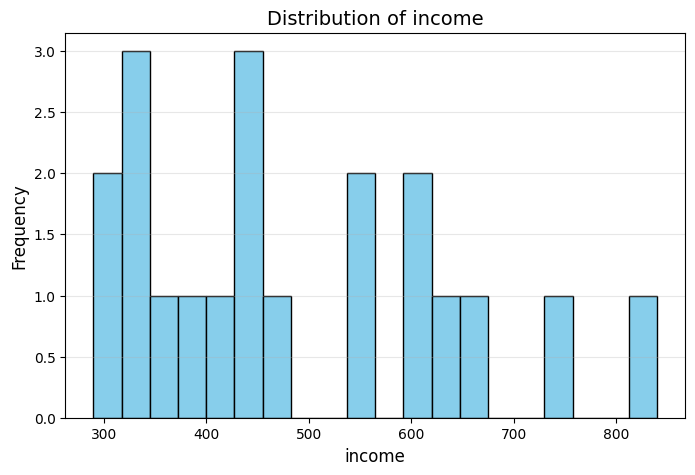

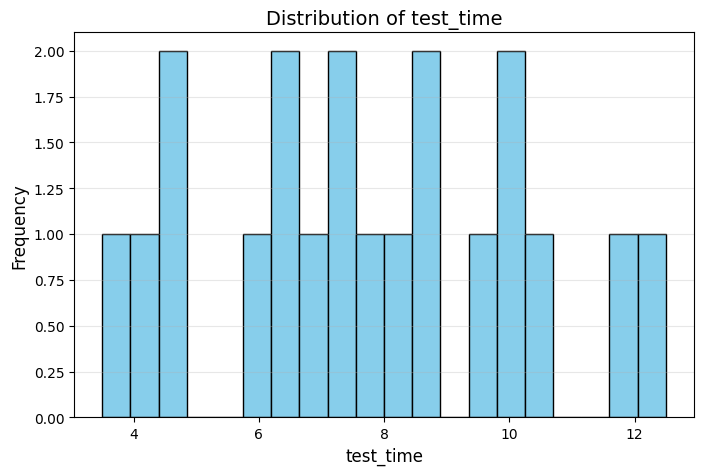

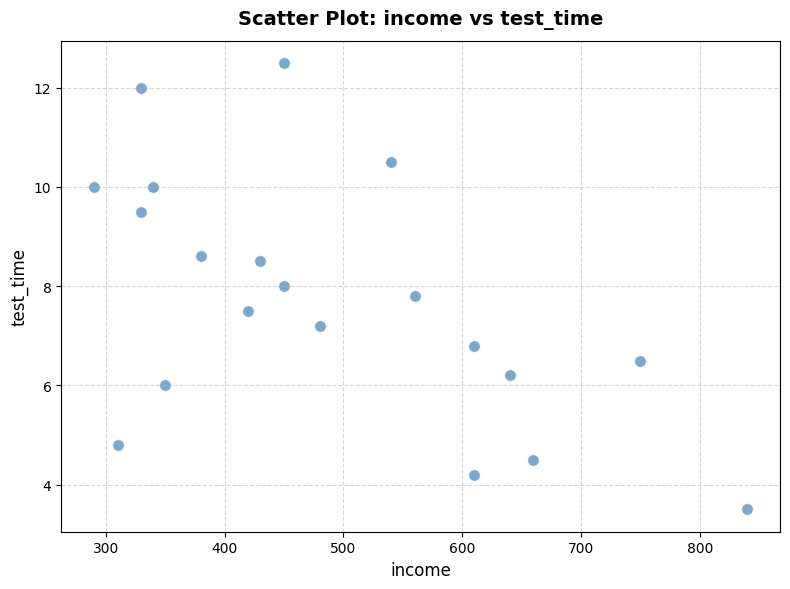

In [4]:
# гистограммы
def print_hist_column(column: str, bins: int = 20, color: str = 'skyblue') -> None:
    if column not in my_df.columns:
        print(f"Error: Column '{column}' not found in DataFrame.")
        return
    data = my_df[column]
    plt.figure(figsize=(8, 5))
    plt.hist(data, bins=bins, color=color, edgecolor='black')
    plt.title(f'Distribution of {column}', fontsize=14)
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    plt.show()

print_hist_column(first_column)
print_hist_column(second_column)

# График рассеяния (scatter plot)
fig_size = (8, 6)

plt.figure(figsize=fig_size)
sns.scatterplot(
    data=df,
    x=first_column,
    y=second_column,
    color="steelblue",
    edgecolor="white",
    s=70,
    alpha=0.7
)

plt.title(f"Scatter Plot: {first_column} vs {second_column}", fontsize=14, fontweight="bold", pad=12)
plt.xlabel(first_column, fontsize=12)
plt.ylabel(second_column, fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# Анализ распределений:

**Распределение дохода (income)**:
- **Форма**: Скошено вправо (правосторонняя асимметрия)
- **Диапазон**: От ~300 до ~800
- **Мода**: Наибольшая частота в районе 400-500
- **Особенности**: Большинство наблюдений сосредоточено в левой части распределения

**Распределение времени тестирования (test_time)**:
- **Форма**: Несколько пиков
- **Диапазон**: От ~4 до ~12
- **Моды**: Пики около 5, 6.5, 7, 9, 10  единиц времени

# Анализ диаграммы рассеяния:

- **Отрицательная тенденция**: При увеличении дохода время тестирования в целом уменьшается
- **Неоднородность связи**: Зависимость не является строго линейной

## 3. Уравнение регрессии
Построить уравнение регрессии методом наименьших квадратов по видам:
1. линейная, $y=w_1 x + w_0$ - расчёт коэффициентов реализовать саммому
2. квадратичная, $y = w_2 x^2 + w_1 x + w_0$
3. гиперболическая, $y = \frac{w_1}{x} + w_0$ 
4. показательная, $y = w_1^x \cdot w_0$

In [5]:

def linear_regression(x, y):
    """Линейная регрессия: y = w1*x + w0"""
    n = len(x)
    
    sum_x = np.sum(x)
    sum_y = np.sum(y)
    sum_xy = np.sum(x * y)
    sum_x2 = np.sum(x**2)
    
    w1 = (n * sum_xy - sum_x * sum_y) / (n * sum_x2 - sum_x**2)
    w0 = (sum_y - w1 * sum_x) / n
    
    return w1, w0

def quadratic_regression(x, y):
    """Квадратичная регрессия: y = w2*x² + w1*x + w0"""
    n = len(x)
    
    sum_x = np.sum(x)
    sum_x2 = np.sum(x**2)
    sum_x3 = np.sum(x**3)
    sum_x4 = np.sum(x**4)
    sum_y = np.sum(y)
    sum_xy = np.sum(x * y)
    sum_x2y = np.sum(x**2 * y)
        
    A = np.array([
        [n, sum_x, sum_x2],
        [sum_x, sum_x2, sum_x3],
        [sum_x2, sum_x3, sum_x4]
    ])
    
    B = np.array([sum_y, sum_xy, sum_x2y])
    w0, w1, w2 = np.linalg.solve(A, B)
    return w2, w1, w0

def hyperbolic_regression(x, y):
    """Гиперболическая регрессия: y = w1/x + w0"""
    x_transformed = 1 / x
    w1, w0 = linear_regression(x_transformed, y)
    return w1, w0

def exponential_regression(x, y):
    """Показательная регрессия: y = w1^x * w0"""    
    if np.any(y <= 0):
        raise ValueError("Для показательной регрессии все значения y должны быть положительными")
    ln_y = np.log(y)
    ln_w1, ln_w0 = linear_regression(x, ln_y)
    w1 = np.exp(ln_w1)
    w0 = np.exp(ln_w0)
    return w1, w0


x = df[first_column].to_numpy()
y = df[second_column].to_numpy()

# 1. Линейная регрессия
w1_lin, w0_lin = linear_regression(x, y)
print(f"1. Линейная регрессия:")
print(f"   y = {w1_lin:.4f} * x + {w0_lin:.4f}")
print(f"   Коэффициенты: w1 = {w1_lin:.4f}, w0 = {w0_lin:.4f}")
print()

# 2. Квадратичная регрессия
w2_quad, w1_quad, w0_quad = quadratic_regression(x, y)
print(f"2. Квадратичная регрессия:")
print(f"   y = {w2_quad:.6f} * x² + {w1_quad:.4f} * x + {w0_quad:.4f}")
print(f"   Коэффициенты: w2 = {w2_quad:.4f}, w1 = {w1_quad:.4f}, w0 = {w0_quad:.4f}")
print()

# 3. Гиперболическая регрессия
w1_hyp, w0_hyp = hyperbolic_regression(x, y)
print(f"3. Гиперболическая регрессия:")
print(f"   y = {w1_hyp:.4f} / x + {w0_hyp:.4f}")
print(f"   Коэффициенты: w1 = {w1_hyp:.4f}, w0 = {w0_hyp:.4f}")
print()

# 4. Показательная регрессия
try:
    w1_exp, w0_exp = exponential_regression(x, y)
    print(f"4. Показательная регрессия:")
    print(f"   y = {w1_exp:.4f}^x * {w0_exp:.4f}")
    print(f"   Коэффициенты: w1 = {w1_exp:.4f}, w0 = {w0_exp:.4f}")
except ValueError as e:
    print(f"4. Показательная регрессия: невозможно вычислить - {e}")
    


1. Линейная регрессия:
   y = -0.0092 * x + 12.2089
   Коэффициенты: w1 = -0.0092, w0 = 12.2089

2. Квадратичная регрессия:
   y = -0.000018 * x² + 0.0097 * x + 7.6017
   Коэффициенты: w2 = -0.0000, w1 = 0.0097, w0 = 7.6017

3. Гиперболическая регрессия:
   y = 1832.3465 / x + 3.6149
   Коэффициенты: w1 = 1832.3465, w0 = 3.6149

4. Показательная регрессия:
   y = 0.9987^x * 14.1216
   Коэффициенты: w1 = 0.9987, w0 = 14.1216


**Линейная модель** (y = -0.0092x + 12.2089)
- **Очень слабая отрицательная связь** - коэффициент w1 ≈ -0.0092 близок к нулю
- При увеличении x на 1 единицу, y уменьшается всего на 0.0092
- **Низкая объясняющая способность** - практически горизонтальная линия

**Квадратичная модель** (y = -0.0000x² + 0.0097x + 7.6017)
- **Квадратичный член практически нулевой** (w2 ≈ 0)
- Фактически вырождается в линейную модель: y ≈ 0.0097x + 7.6017
- **Отсутствие квадратичной зависимости** в данных

**Гиперболическая модель** (y = 1832.3465/x + 3.6149)
- **Наиболее выраженная зависимость** среди всех моделей
- Сильный коэффициент w1 = 1832.35 указывает на существенное влияние
- При больших x значение y стремится к 3.6149 (горизонтальная асимптота)
- **Наиболее перспективная модель** для данных

**Показательная модель** (y = 0.9987ˣ × 14.1216)
- **Очень медленное убывание** - основание степени 0.9987 близко к 1
- Практически постоянная функция с небольшим спадом
- **Слабая объясняющая способность**


Показать результаты на графиках

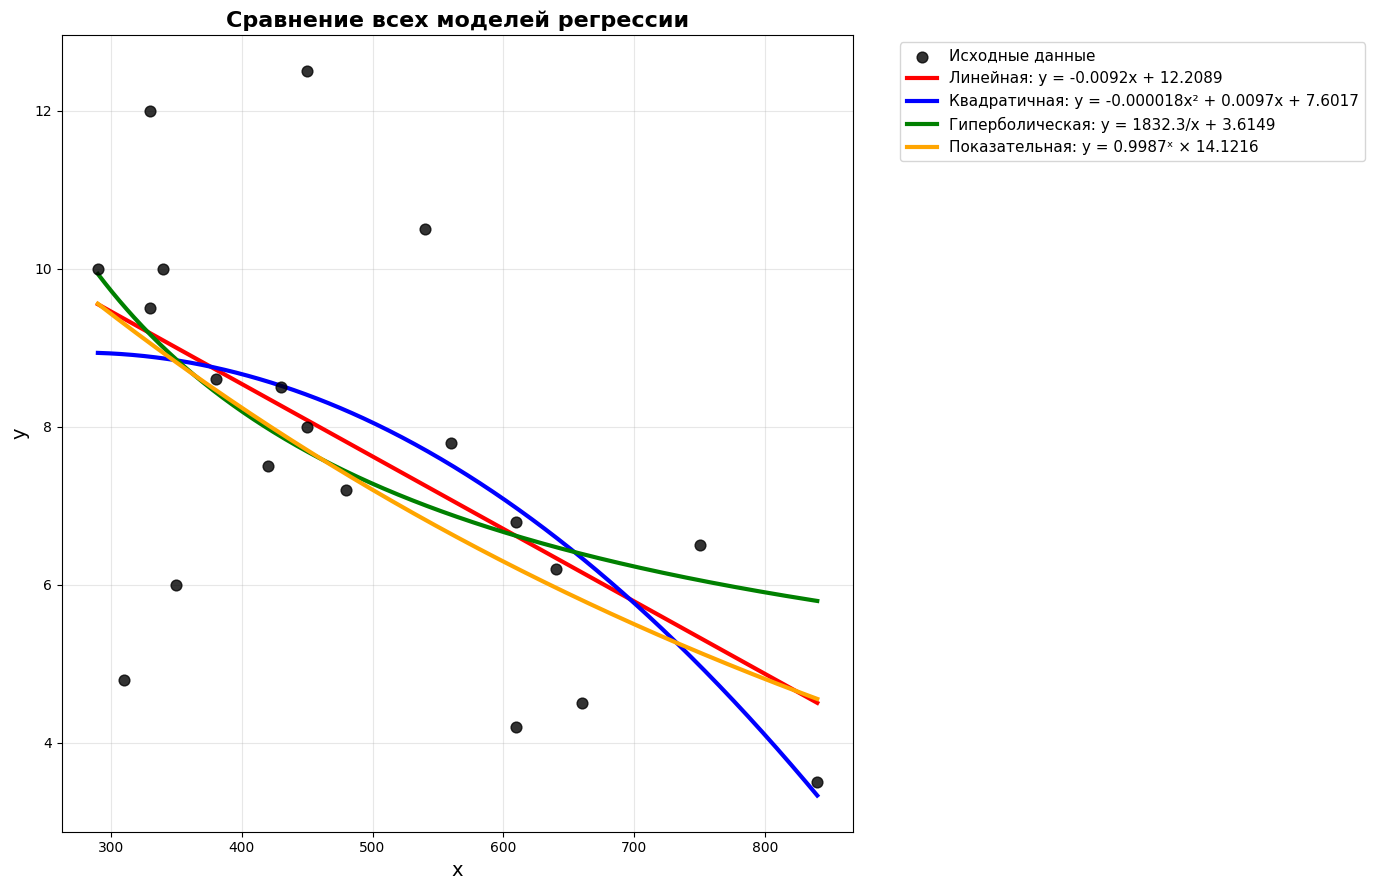

In [8]:
plt.figure(figsize=(14, 9))

x_range = np.linspace(x.min(), x.max(), 500)

plt.scatter(x, y, alpha=0.8, label='Исходные данные', color='black', s=60, zorder=5)

# Линейная регрессия
y_lin = w1_lin * x_range + w0_lin
plt.plot(x_range, y_lin, color='red', linewidth=3, 
         label=f'Линейная: y = {w1_lin:.4f}x + {w0_lin:.4f}')

# Квадратичная регрессия
y_quad = w2_quad * x_range**2 + w1_quad * x_range + w0_quad
plt.plot(x_range, y_quad, color='blue', linewidth=3,
         label=f'Квадратичная: y = {w2_quad:.6f}x² + {w1_quad:.4f}x + {w0_quad:.4f}')

# Гиперболическая регрессия
x_hyp_range = x_range[x_range != 0]
y_hyp = w1_hyp / x_hyp_range + w0_hyp
plt.plot(x_hyp_range, y_hyp, color='green', linewidth=3,
         label=f'Гиперболическая: y = {w1_hyp:.1f}/x + {w0_hyp:.4f}')

# Показательная регрессия
y_exp = w1_exp**x_range * w0_exp
plt.plot(x_range, y_exp, color='orange', linewidth=3,
         label=f'Показательная: y = {w1_exp:.4f}ˣ × {w0_exp:.4f}')

plt.title('Сравнение всех моделей регрессии', fontsize=16, fontweight='bold')
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

## 4. Проверка уравнения регрессии
Для наилучшего и наихудшего уравнения регрессии проверить соотвествие моедли данным с помощью критерия Фишера

In [10]:
def fisher_test(x: np.ndarray, y: np.ndarray, y_pred: np.ndarray, k: int, model_name: str):
    n = len(x)
    y_mean = np.mean(y)

    S_t = np.sum((y - y_mean) ** 2)
    S_r = np.sum((y_pred - y_mean) ** 2)
    S_e = np.sum((y - y_pred) ** 2)

    F = (S_r / k) / (S_e / (n - k - 1))
    F_crit = stats.f.ppf(0.99, k, n - k - 1)

    print(f"{model_name}")
    print(f"F = {F:.3f}, F_кр = {F_crit:.3f}")
    if F > F_crit:
        print("Модель значима (хорошо описывает данные)")
    else:
        print("Модель незначима (плохое соответствие данным)")
    print()
    return F, F_crit

y_pred_lin = w1_lin * x + w0_lin
F, F_crit = fisher_test(x, y, y_pred_lin, k=1, model_name="Линейная модель")

y_pred_quad = w2_quad * x**2 + w1_quad * x + w0_quad
F, F_crit = fisher_test(x, y, y_pred_quad, k=2, model_name="Квадратичная модель")

y_pred_hyp = w1_hyp / x + w0_hyp
F, F_crit = fisher_test(x, y, y_pred_hyp, k=1, model_name="Гиперболическая модель")


ln_y = np.log(y)
y_pred_exp = w0_exp * (w1_exp ** x)
F, F_crit = fisher_test(x, y, y_pred_exp, k=1, model_name="Показательная модель")

Линейная модель
F = 8.658, F_кр = 8.285
Модель значима (хорошо описывает данные)

Квадратичная модель
F = 4.661, F_кр = 6.112
Модель незначима (плохое соответствие данным)

Гиперболическая модель
F = 5.771, F_кр = 8.285
Модель незначима (плохое соответствие данным)

Показательная модель
F = 8.969, F_кр = 8.285
Модель значима (хорошо описывает данные)



**Лучшие модели: Линейная и Показательная**

**Наихудшие модели: Квадратичная и Гиперболическая**

# Алгоритм проверки уравнения регрессии (критерий Фишера)

**Вычислить среднее значение:**
   $ \bar{y} = \frac{1}{n} \sum_{i=1}^{n} y_i $

**Вычислить суммы квадратов:**
   - **Общая дисперсия:**
     $ S_t = \sum (y_i - \bar{y})^2 $
   - **Объяснённая регрессией:**
     $ S_r = \sum (\hat{y}_i - \bar{y})^2 $
   - **Остаточная (ошибки):**
     $ S_e = \sum (y_i - \hat{y}_i)^2 $

**Вычислить наблюдаемое значение критерия Фишера:**
   $ F = \frac{S_r / k}{S_e / (n - k - 1)} $

   где  
   $ n $ — количество наблюдений,  
   $ k $ — число коэффициентов модели (без свободного члена).

**Найти критическое значение:**
   $ F_{\text{кр}} = F_{1 - \alpha}(k, n - k - 1) $

   (по таблице распределения Фишера при уровне значимости $ \alpha = 0.05 $)

**Сделать вывод:**
   - Если $ F > F_{\text{кр}} $ → **модель значима**  
   - Если $ F \le F_{\text{кр}} $ → **модель незначима**

